In [1]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
from scipy.sparse.linalg import lsqr
import scipy as sp
import rioxarray
from gravbox import * 
from tqdm import tqdm

# Plotting maps using GMT
import pygmt
import geopandas as gpd

# The Fatiando stack
import harmonica as hm
from grav_column_der import grav_column_der

# RIS tight extent
e_fig = -560000
w_fig = 400000
n_fig = -1400000
s_fig = -440000

# RIS zoomed in extent
zoom = 400e3
e_fig = -560000+zoom
w_fig = 400000-zoom
n_fig = -1400000+zoom
s_fig = -440000-zoom

# RIS zoomed and south shifted extent
# zoom = 400e3
# shift = 200e3
# e_fig = -560000+zoom
# w_fig = 400000-zoom
# n_fig = -1400000+zoom-shift
# s_fig = -440000-zoom-shift

fig_reg = [e_fig, w_fig, n_fig, s_fig]

fig_height = 80
fig_width = fig_height*(w_fig-e_fig)/(s_fig-n_fig)
fig_ratio = (s_fig-n_fig)/(fig_height/1000)
fig_proj = f"x1:{fig_ratio}"
fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"
fig_reg_ll = "-180/180/-90/-71"
buffer = 100e3

e_inv = int(e_fig-buffer)
w_inv = int(w_fig+buffer)
n_inv = int(n_fig-buffer)
s_inv = int(s_fig+buffer)
inv_reg = [e_inv, w_inv, n_inv, s_inv]
inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'

inv_height = 80
inv_width = inv_height*(w_inv-e_inv)/(s_inv-n_inv)
inv_ratio = (s_inv-n_inv)/(inv_height/1000)
inv_proj = f"x1:{inv_ratio}"
inv_proj_ll = f"s0/-90/-71/1:{inv_ratio}"

# region for clipping grids in RIS_bathymetry_data.ipynb
# buffer = 200e3
# e_regional = int(e_inv-buffer)
# w_regional = int(w_inv+buffer)
# n_regional = int(n_inv-buffer)
# s_regional = int(s_inv+buffer)
# regional_reg = [e_regional, w_regional, n_regional, s_regional]
# regional_reg

def plot_coast(projection = fig_proj, region = fig_reg):
        fig.plot(
                projection = projection, 
                region = region,
                data = gpd.read_file('C:/Users\matthewt\Documents\Python_Scripts\RIS_gravity_inversion\plotting\GroundingLine_Antarctica_v02.shp'), 
                pen = '1.2p,black', 
                verbose='q',
                )
        fig.plot(data = gpd.read_file('C:/Users\matthewt\Documents\Python_Scripts\RIS_gravity_inversion\plotting\Coastline_Antarctica_v02.shp'), 
                pen = '1.2p,black',
                verbose='q',
                )

def plot_constraints(projection = fig_proj, region = fig_reg, df = None):
        if df is None:
                df = constraints_RIS_df
        fig.plot(
                x = df.x, 
                y = df.y, 
                style = 'c1.2p',
                color = 'black',
                projection = projection,
                region = region, 
                )

def plot_inv_box(projection = fig_proj, region = fig_reg):
        fig.plot(
                x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
                y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
                pen = '2p,black', 
                projection = projection,
                region = region,
                )

# To Do
* add plotting function
    * choose between fast mpl and slow pygmt
* interpolate regional gravity to full inv_reg
* add actual grav observation elevations
* use discretize package to increase grid spacing outside of fig_reg
* implement scipy optimize to compare with grav_column_der
* add control points to inversion constraints
* update layer above active layer for geometry inversion
* fix density inversion
* implement vertically increasing density to both ice and sediment (like harmonica.tesseroid_gravity)

# Import data

In [2]:

layers_list =[
             'ice',
             'water',
             'layer1',
             'layer2',
]
spacing_list = [
                20e3,
                20e3,
                20e3,
                20e3,
]
rho_list = [
            920,
            1030,
            2600,
            2800,
]

grav_spacing = 20e3

# fig_reg_str=f'{e_fig}/{w_fig}/{n_fig}/{s_fig}'
inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
# resample gravity to just within the figure region (without buffer)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{grav_spacing}  gravity_data/ant4d_gravity.nc -Ginversion_layers/gravity_inv.nc
# resample layer grids to inversion region (with buffer)
# surface (ice)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[0]}  inversion_layers/bedmachine/BedMachine_surface_5k_filled.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# icebase (water)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[1]}  inversion_layers/bedmachine/BedMachine_icebase_5k_filled.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# bathymetry (sediment)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[2]}  bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[2]}  inversion_layers/bedmachine/BedMachine_bed_5k.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# basement (crust)
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[3]}  inversion_layers/ANTASed_mag_basement_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[3]}  inversion_layers/RE_basement_BedMachinebed_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 


# Fabio's test grids
# !gmt grdsample -R{inv_reg_str} -rg -I{grav_spacing}  inversion_layers/base_RIS_gravity_10000m_lr.nc -Ginversion_layers/gravity_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[0]}  inversion_layers/base_RIS_ice_10000m_lr.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[1]}  inversion_layers/base_RIS_water_10000m_lr.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[2]}  inversion_layers/base_RIS_layer1_10000m_lr.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -I{spacing_list[3]}  inversion_layers/base_RIS_layer2_20000m_lr.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 




# add bathymetry control points
!gmt grdsample -R{inv_reg_str} -rg -Vn -I1000 inversion_layers/constraints_grid.nc -Ginversion_layers/constraints_grid.nc 
fname = 'inversion_layers/constraints_grid.nc'
constraints_grid = xr.load_dataset(fname)

fname = 'bathymetry_data/bedmachine_RIGGS.csv'
constraints_df =  pd.read_csv(fname, index_col=False)

!gmt grdmask ../Documents/QGIS/Shapefiles/MEaSUREs_RIS.shp -Gplotting/RIS_GL_mask_outer.nc -I1000 -R{inv_reg_str} -NNaN/NaN/1
constraints_RIS_df = pygmt.select(data=constraints_df, gridmask='plotting/RIS_GL_mask_outer.nc')

fname_list=[
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc',
            ]

layers = {j:{'spacing':spacing_list[i], 
            'fname':fname_list[i], 
            'rho':rho_list[i]} for i, j in enumerate(layers_list)}

for k, v in layers.items():
    v['grid']=xr.load_dataset(v['fname'])
    v['df']=xr.load_dataset(v['fname']).to_dataframe().reset_index()
    v['df']['rho']=v['rho']
    v['df'].dropna(how='any', inplace=True)
    # v['grid']=pygmt.xyz2grd(v['df'][['x','y','z']], region=inv_reg, spacing=v['spacing'])
    # v['grid']=v['grid'].to_dataset(name='z')
    # v['grid']
    v['len']=len(v['df'].x)  

fname='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/gravity_inv.nc'
grid_grav = xr.load_dataset(fname)           
df_grav = xr.load_dataset(fname).to_dataframe().reset_index() 
df_grav.rename(columns={'z':'Gobs'}, inplace=True)
df_grav.dropna(how='any', inplace=True)
df_grav['z']=layers['ice']['grid'].to_dataframe().reset_index().z+750
# grid_grav=pygmt.xyz2grd(df_grav[['x','y','Gobs']], region=inv_reg, spacing=grav_spacing)
# grid_grav=grid_grav.to_dataset(name='z')

for k, v in layers.items():
    print(f"points in {k} file: {v['len']}") 

print(f'points in gravity file: {len(df_grav)}')    
print(f'number of strict bathymetry control points:{len(constraints_df)}')    

points in ice file: 361
points in water file: 361
points in layer1 file: 361
points in layer2 file: 361
points in gravity file: 361
number of strict bathymetry control points:10475932


# Show layers

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


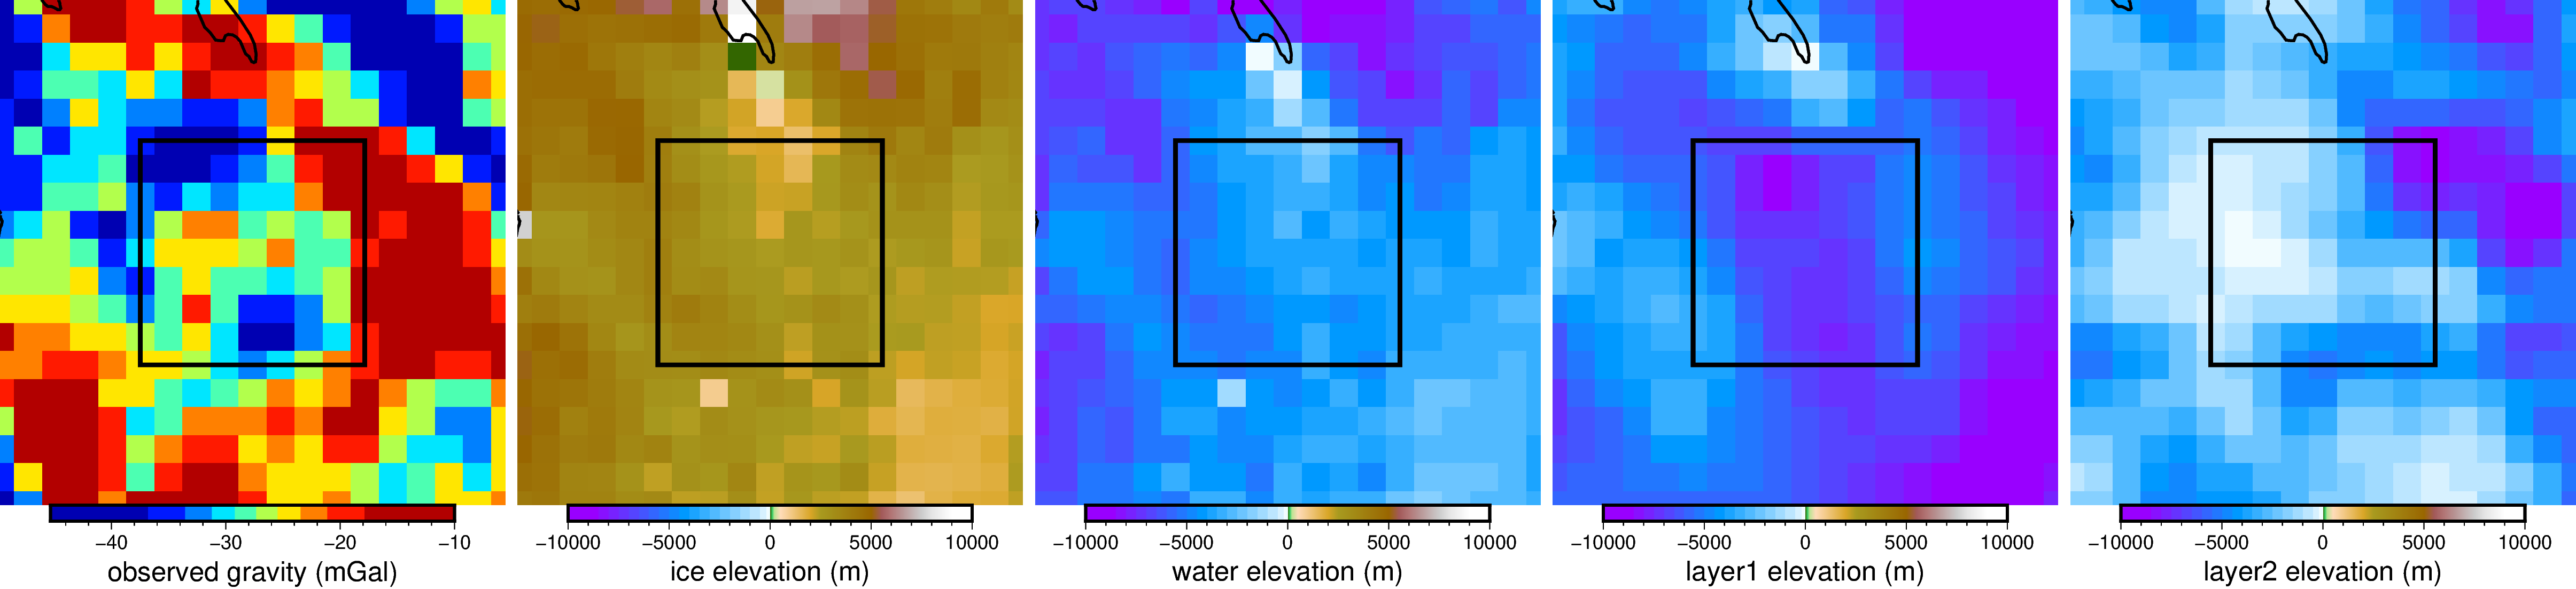

In [3]:
plot_region = inv_reg
cmap_region = fig_reg

if plot_region == inv_reg:
    projection = inv_proj
    plot_width = inv_width
elif plot_region == fig_reg:
    projection = fig_proj
    plot_width = fig_width

fig = pygmt.Figure()

pygmt.grd2cpt(cmap="jet", grid=grid_grav.z, region=cmap_region, background=True)
fig.grdimage(
    grid_grav.z,
    cmap=True,
    projection=projection, 
    region=plot_region,
    nan_transparent=True,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='x+l"observed gravity (mGal)"')

if plot_region == inv_reg:
    plot_inv_box(projection=projection, region=plot_region)

plot_coast(projection=projection, region=plot_region)

fig.shift_origin(xshift=(inv_width+2)/10)

for i, (k, v) in enumerate(layers.items()):
    data=layers[k]['grid'].z
    fig.grdimage(
        data,
        cmap='globe',
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
    fig.colorbar(cmap='globe', position='jBC+jTC+h', frame=f'x+l"{k} elevation (m)"')

    if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

    plot_coast(projection=projection, region=plot_region)

    # if k == 'layer1':
    #     plot_constraints(region=plot_region, projection=projection, df=constraints_df)

    fig.shift_origin(xshift=(inv_width+2)/10)

fig.show()

# Forward gravity calculations of layers

In [4]:
# Calculate inital forward gravity model of input layer
# add density variable to datasets
for k ,v in layers.items():
    v['grid']['density']=v['grid'].z.copy()
    v['grid'].density.values[:] = v['rho']

# list of layers, bottom up
reversed_layers_list = np.flip(layers_list[:])

for i, j in enumerate(reversed_layers_list):
    if i == 0:
        layers[j]['prisms']=hm.prism_layer(
            coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
            surface=layers[j]['grid'].z, 
            # reference=-5e3,
            reference = np.nanmin(layers[j]['grid'].z.values)*2, # bottom of prisms is twice the deepest depth
            properties={'density':layers[j]['grid'].density})
        print(f'mean elevation of {j} top: {np.nanmean(layers[j]["prisms"].top.values)} and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}')

    else:
        if layers[j]['spacing'] != layers[reversed_layers_list[i-1]]['spacing']:
            print(f"resolutions don't match for {j} ({layers[j]['spacing']}m) and {reversed_layers_list[i-1]} ({layers[reversed_layers_list[i-1]]['spacing']}m)")
            print(f"resampling {reversed_layers_list[i-1]} to match {j}")
            tmp = layers[j]['grid'].z.to_dataframe().reset_index()
            tmp_regrid = pygmt.grdtrack(points = tmp[['x','y']], 
                                        grid = layers[reversed_layers_list[i-1]]['grid'].z, 
                                        newcolname = 'z_regrid')
            tmp['z_low']=tmp.merge(tmp_regrid, how = 'left', on = ['x','y']).z_regrid
            tmp_grd = pygmt.xyz2grd(tmp[['x','y','z_low']], region = inv_reg, spacing = layers[j]['spacing'])

            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'].z, 
                reference=tmp_grd,
                properties={'density':layers[j]['grid'].density})
            print(f'mean elevation of {j} top: {np.nanmean(layers[j]["prisms"].top.values)} and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}')
        else:
            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'].z, 
                reference=layers[reversed_layers_list[i-1]]['grid'].z,
                properties={'density':layers[j]['grid'].density})
            print(f'mean elevation of {j} top: {np.nanmean(layers[j]["prisms"].top.values)} and bottom: {np.nanmean(layers[j]["prisms"].bottom.values)}')

print('starting forward gravity calculations and gridding')
for k, v in layers.items():
    df_grav[f'{k}_forward_grav'] = v['prisms'].prism_layer.gravity(
        coordinates = (df_grav.x, df_grav.y, df_grav.z),
        field = 'g_z', progressbar=True)
    print(f'finished {k} layer')
    layers[k]['forward_grav'] = pygmt.xyz2grd(data=df_grav[['x','y',f'{k}_forward_grav']],
                        region=inv_reg, spacing=grav_spacing, projection=inv_proj) 

# add gravity effects of all input layers
for i, j in enumerate(layers_list):
    if i == 0:
        df_grav['forward_grav_total'] = df_grav[f'{j}_forward_grav']
    else:
        df_grav['forward_grav_total'] += df_grav[f'{j}_forward_grav']

df_grav.describe()


mean elevation of layer2 top: -1998.8656005859375 and bottom: -9191.3544921875
mean elevation of layer1 top: -564.7354736328125 and bottom: -1998.8656005859375
mean elevation of water top: -340.7975158691406 and bottom: -565.0035400390625
mean elevation of ice top: 41.010684967041016 and bottom: -341.0655822753906
starting forward gravity calculations and gridding
100%|██████████| 361.0/361 [00:02<00:00, 164.80it/s] 
finished ice layer
100%|██████████| 361.0/361 [00:00<00:00, 18098.13it/s]
finished water layer
100%|██████████| 361.0/361 [00:00<00:00, 19050.39it/s]
finished layer1 layer
100%|██████████| 361.0/361 [00:00<00:00, 18964.96it/s]
finished layer2 layer


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,layer1_forward_grav,layer2_forward_grav,forward_grav_total
count,361.000000,3.610000e+02,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,-80000.000000,-9.200000e+05,-25.434654,791.010620,14.537267,9.508590,151.089055,775.353063,950.487975
std,109696.551146,1.096966e+05,8.490853,6.480183,2.028814,4.835995,80.098807,110.006046,60.305882
min,-260000.000000,-1.100000e+06,-47.360001,773.107910,8.759277,0.256590,12.373619,498.922911,738.317630
25%,-180000.000000,-1.020000e+06,-30.530001,786.300720,12.995265,5.730153,88.895715,693.669698,936.285972
50%,-80000.000000,-9.200000e+05,-25.600000,790.278076,14.351885,9.418496,143.612574,786.281384,976.100657
75%,20000.000000,-8.200000e+05,-19.350000,794.868652,15.962040,13.362057,197.960049,863.212084,994.289145
max,100000.000000,-7.400000e+05,-3.489999,827.025146,20.580257,19.915315,387.293477,964.761048,1012.035705


# Plot forward gravity of each layer

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


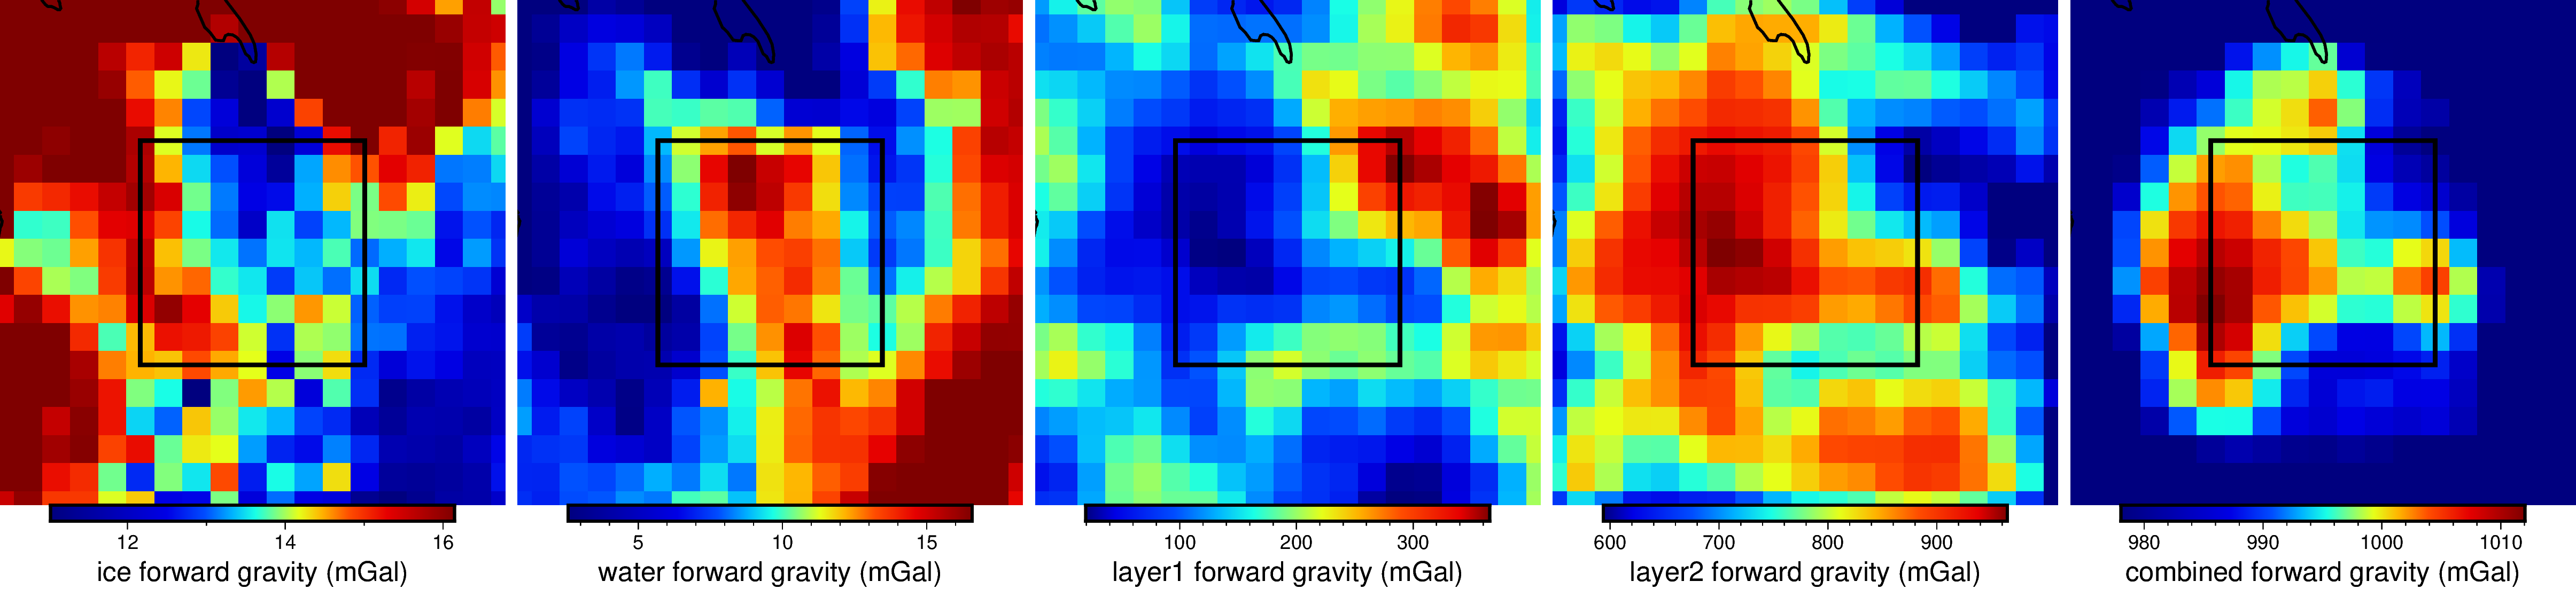

In [5]:
plot_region = inv_reg
cmap_region = fig_reg

if plot_region == inv_reg:
    projection = inv_proj
    plot_width = inv_width
elif plot_region == fig_reg:
    projection = fig_proj
    plot_width = fig_width

fig = pygmt.Figure()

for i, (k, v) in enumerate(layers.items()):
    # data = pygmt.xyz2grd(data=df_grav[['x','y',f'{k}_forward_grav']],
    #                      region=inv_reg, spacing=grav_spacing, projection=inv_proj) 
    data = v['forward_grav']
    try:
        pygmt.grd2cpt(cmap="jet", grid=data, region=cmap_region, background=True, continuous=True)
    except:
        print('cmap error')
        pygmt.makecpt(cmap='jet')
    fig.grdimage(
        data,
        cmap=True,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
    fig.colorbar(cmap=True, position='jBC+jTC+h', frame=f'x+l"{k} forward gravity (mGal)"')
    
    if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)
    
    plot_coast(projection=projection, region=plot_region)

    fig.shift_origin(xshift=(plot_width +2)/10)

data = pygmt.xyz2grd(data=df_grav[['x','y', 'forward_grav_total']],
                         region=inv_reg, spacing=grav_spacing, projection=inv_proj) 
pygmt.grd2cpt(cmap="jet", grid=data, region=cmap_region, background=True, continuous=True)
fig.grdimage(
    data,
    cmap=True,
    projection=projection, 
    region=plot_region,
    nan_transparent=True,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='x+l"combined forward gravity (mGal)"')

if plot_region == inv_reg:
    plot_inv_box(projection=projection, region=plot_region)
plot_coast(projection=projection, region=plot_region)

fig.show()

# Plot observed, misfit, and forward gravity 

In [6]:
# calculate anomalies in gravity dataframe
df_grav['initial_misfit'] = df_grav.Gobs - df_grav.forward_grav_total
shift = df_grav.initial_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
print(f'average initial misfit within figure region is {int(shift)} mGal')

df_grav['Gobs_shift'] = df_grav.Gobs - shift
print(f'average Gobs_shifted: {int(df_grav.Gobs_shift[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')

df_grav['forward_grav_misfit'] = df_grav.Gobs_shift - df_grav.forward_grav_total
misfit_shift = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
print(f'average misfit between Gobs_shift and forward gravity within figure region is {misfit_shift} mGal')


# make grids of anomalies
observed_shift_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','Gobs_shift']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

forward_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_total']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

misfit_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_misfit']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)


# sample Gobs_shift grid at contraint points
tmp_regrid = pygmt.grdtrack(points = constraints_df[['x','y']], 
                            grid = observed_shift_grav_grid,
                            newcolname = 'Gobs_sampled')
constraints_df['Gobs_shift']=constraints_df.merge(tmp_regrid, how = 'left', on = ['x','y']).Gobs_sampled
# grid and interpolate regional field
grid_grav_constraints = pygmt.xyz2grd(constraints_df[['x','y','Gobs_shift']], region = inv_reg, spacing = grav_spacing)
grid_grav_constraints = grid_grav_constraints.rio.write_crs("epsg:3031")
grid_grav_constraints = grid_grav_constraints.rio.interpolate_na(method='cubic')
# add to dataframe
df_grav['regional'] = grid_grav_constraints.transpose().to_dataframe().reset_index().z
grid_grav_constraints = pygmt.xyz2grd(df_grav[['x','y','regional']], region=inv_reg, spacing=grav_spacing)

residual_grav = grid_grav_constraints - observed_shift_grav_grid
regional_misfit_grav_grid = residual_grav - forward_grav_grid

df_grav['regional_misfit'] = df_grav.regional - df_grav.forward_grav_total

average initial misfit within figure region is -1024 mGal
average Gobs_shifted: 997 mGal
average misfit between Gobs_shift and forward gravity within figure region is 3.13363501281519e-05 mGal


grdtrack [WARNING]: Some input points were outside the grid domain(s).


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


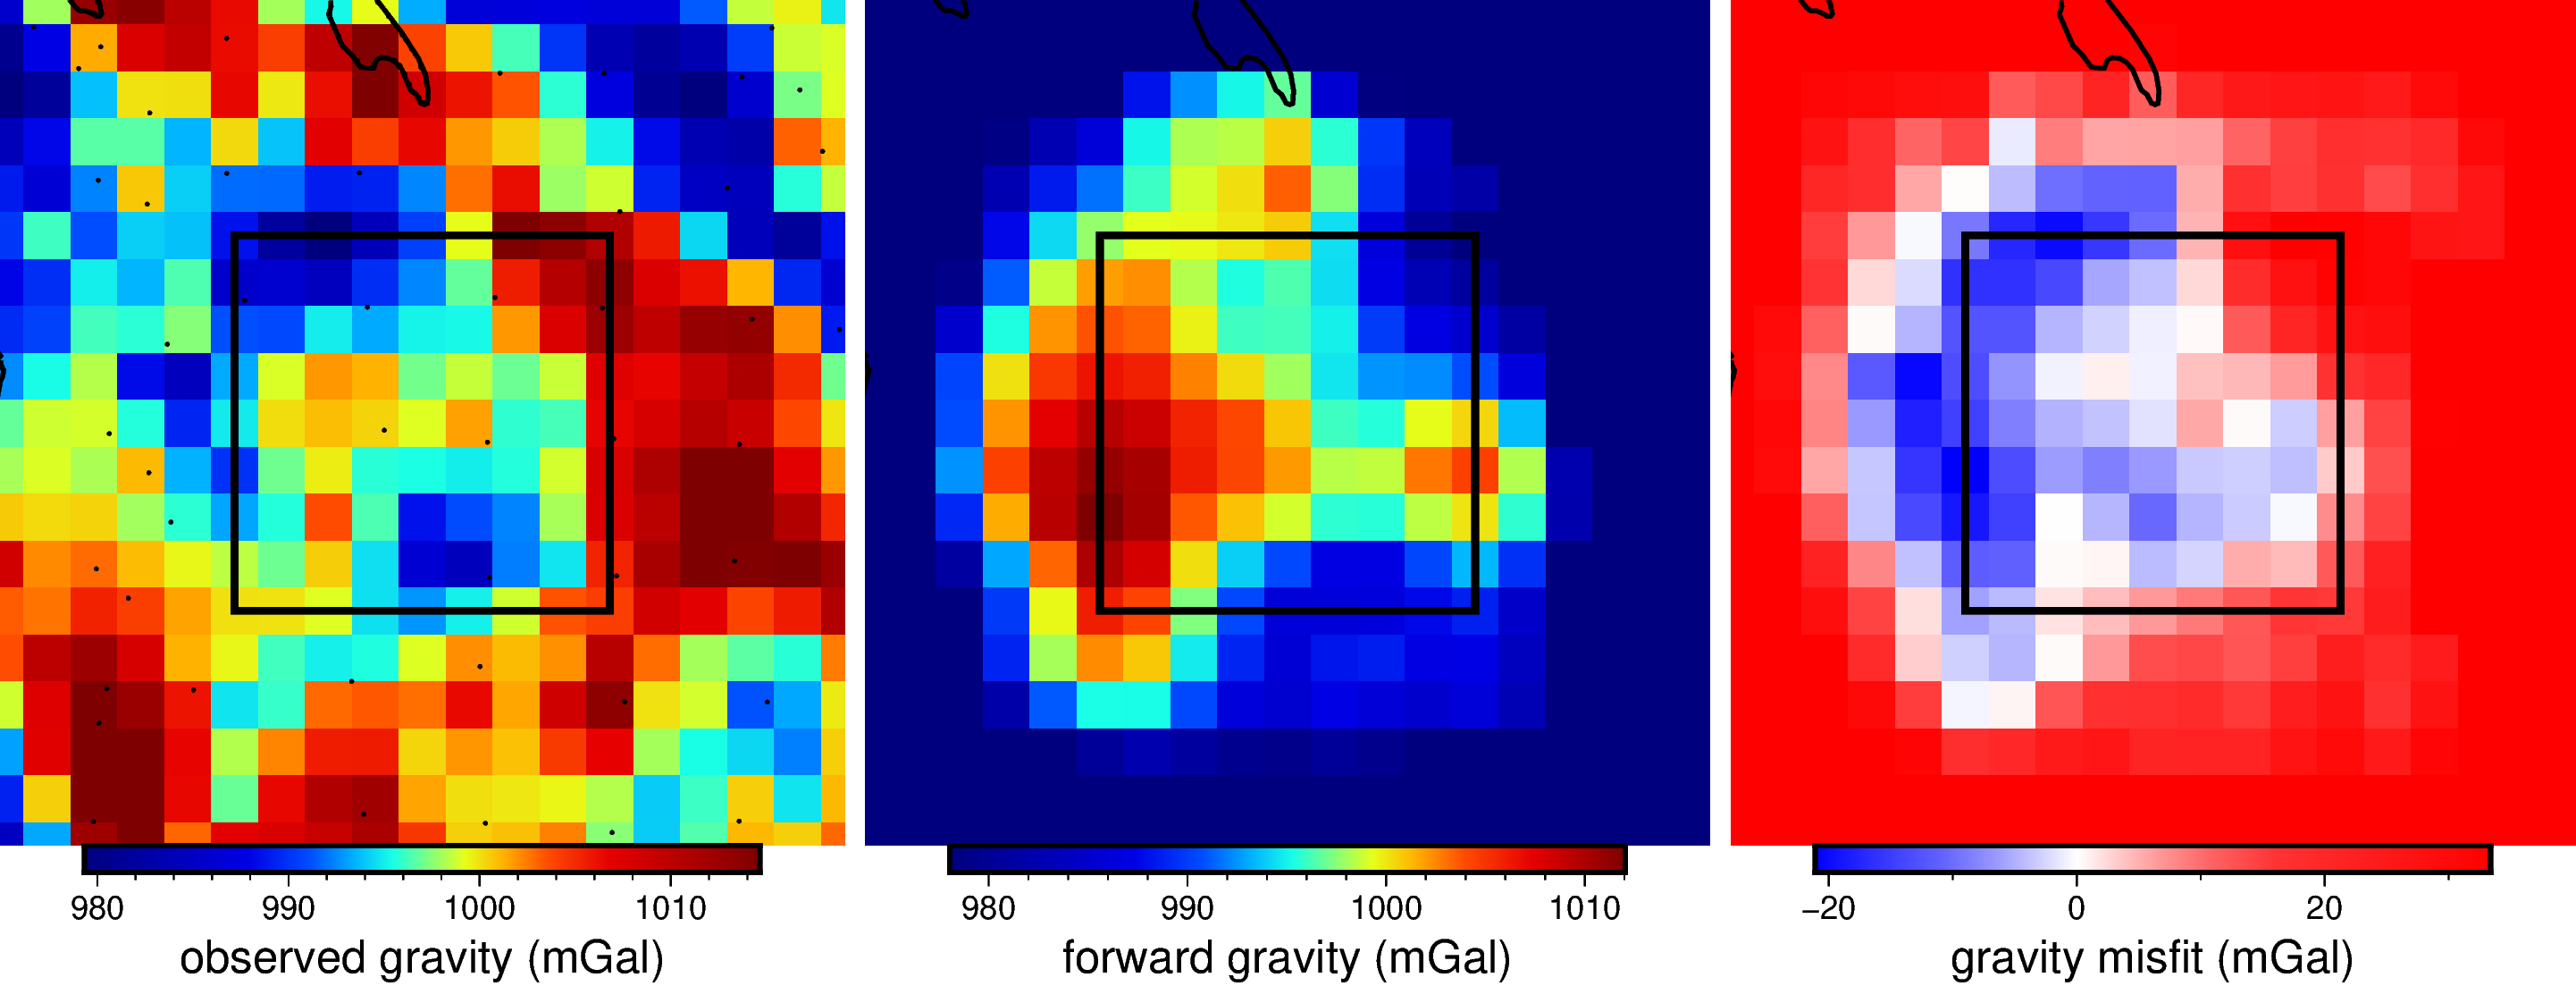

In [7]:
plot_region = inv_reg
cmap_region = fig_reg

if plot_region == inv_reg:
    projection = inv_proj
    plot_width = inv_width
elif plot_region == fig_reg:
    projection = fig_proj
    plot_width = fig_width

fig = pygmt.Figure()

# plot observed gravity
grid=observed_shift_grav_grid
pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"observed gravity (mGal)"')

plot_coast(region=plot_region, projection=projection)
plot_constraints(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)
        
fig.shift_origin(xshift=(plot_width+2)/10)


# plot forward gravity
grid=forward_grav_grid
pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"forward gravity (mGal)"')

plot_coast(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

fig.shift_origin(xshift=(plot_width+2)/10)

# plot misfit gravity
grid=misfit_grav_grid
pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,#'polar+h0',
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"gravity misfit (mGal)"')

plot_coast(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

fig.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


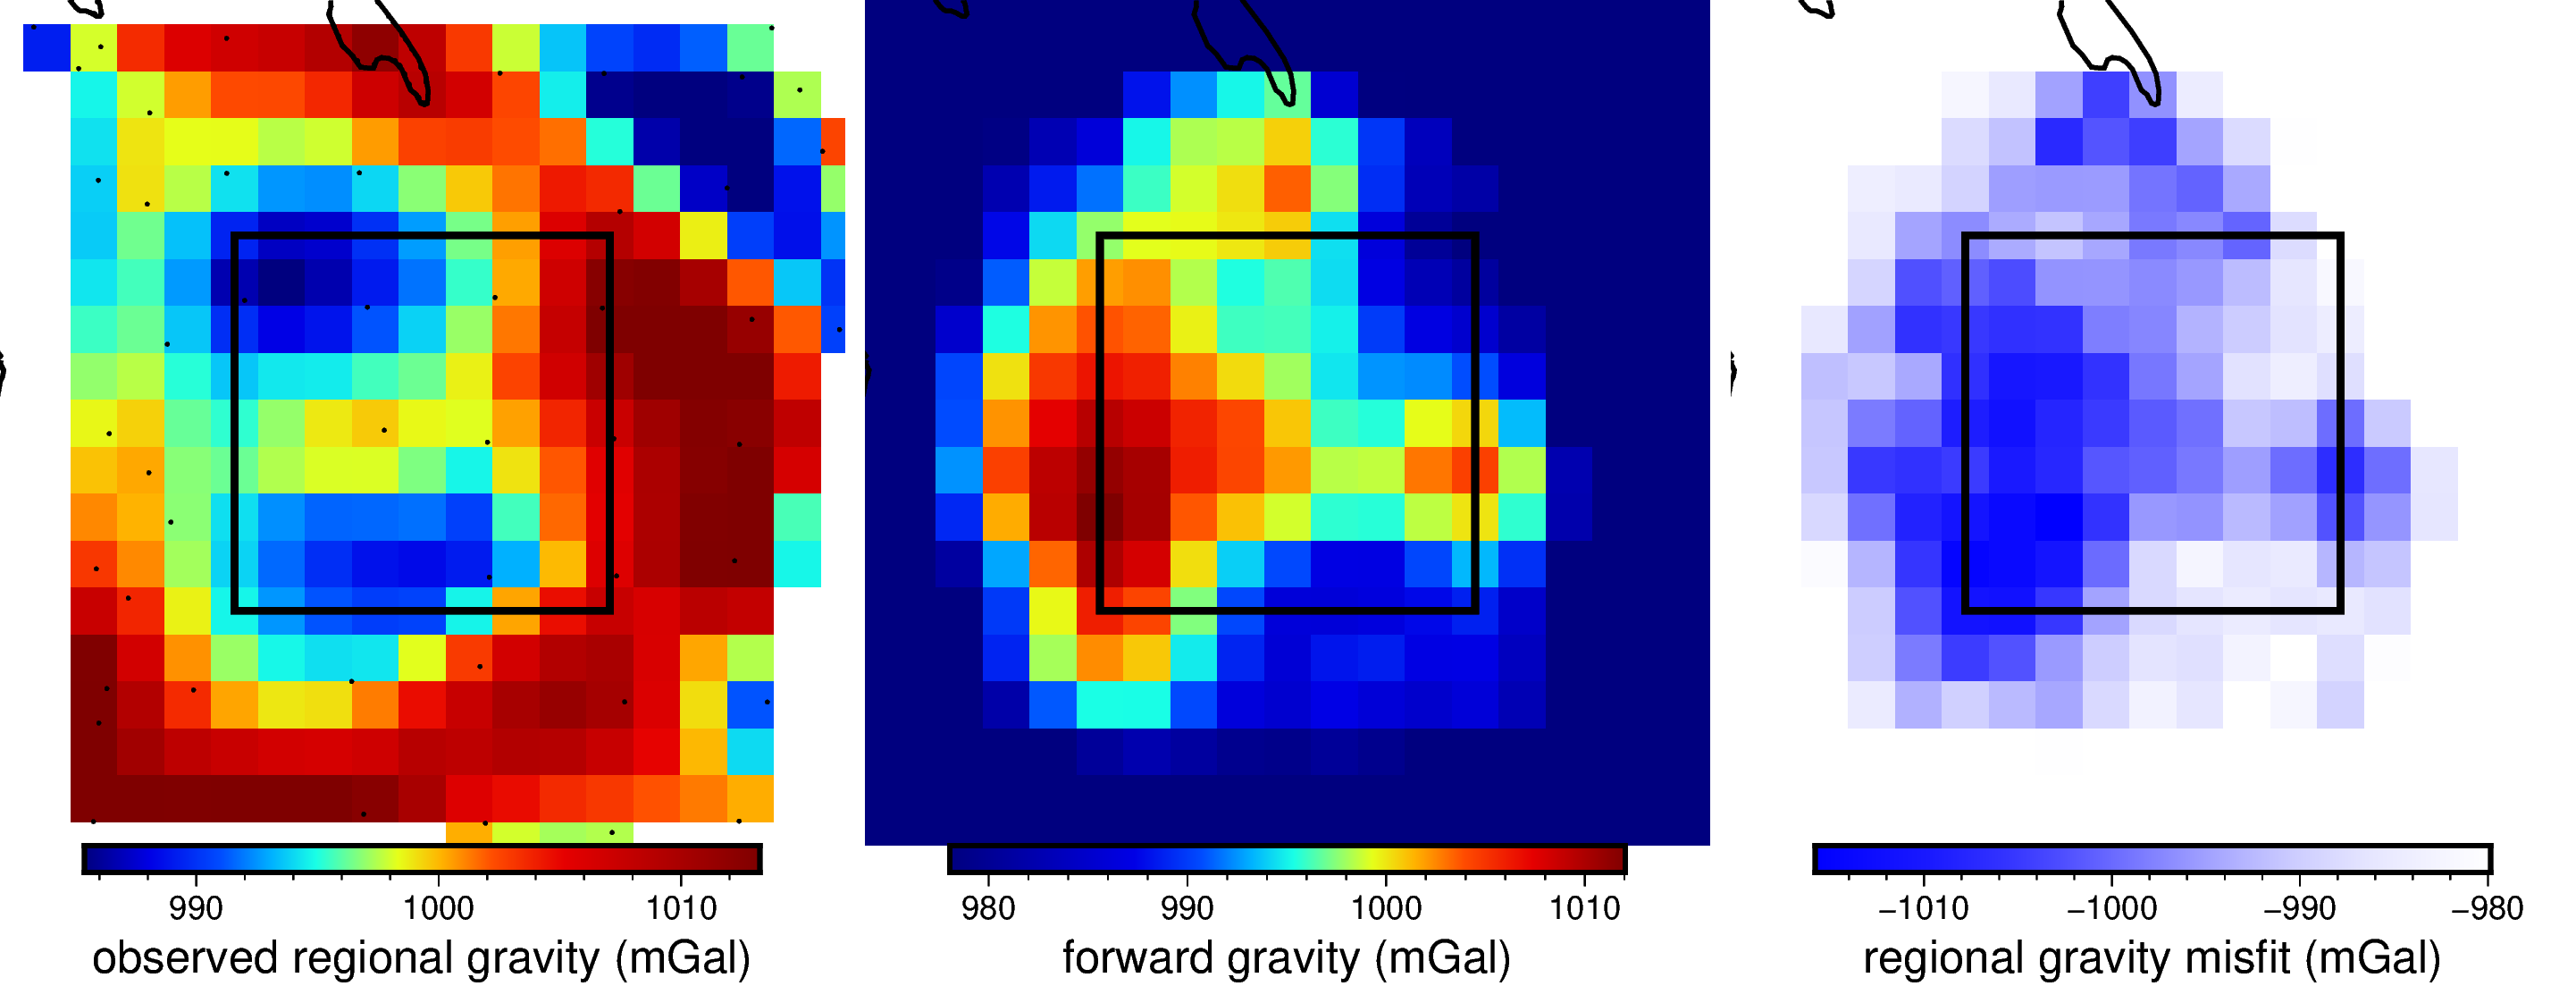

In [8]:
plot_region = inv_reg
cmap_region = fig_reg

if plot_region == inv_reg:
    projection = inv_proj
    plot_width = inv_width
elif plot_region == fig_reg:
    projection = fig_proj
    plot_width = fig_width

fig = pygmt.Figure()

#plot regional gravity (Gobs at control points)
grid=grid_grav_constraints
pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"observed regional gravity (mGal)"')

plot_coast(region=plot_region, projection=projection)
plot_constraints(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)
        
fig.shift_origin(xshift=(plot_width+2)/10)


# plot forward gravity
grid=forward_grav_grid
pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"forward gravity (mGal)"')

plot_coast(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

fig.shift_origin(xshift=(plot_width+2)/10)

# plot misfit gravity
grid=regional_misfit_grav_grid
pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,#'polar+h0',
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"regional gravity misfit (mGal)"')

plot_coast(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

fig.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


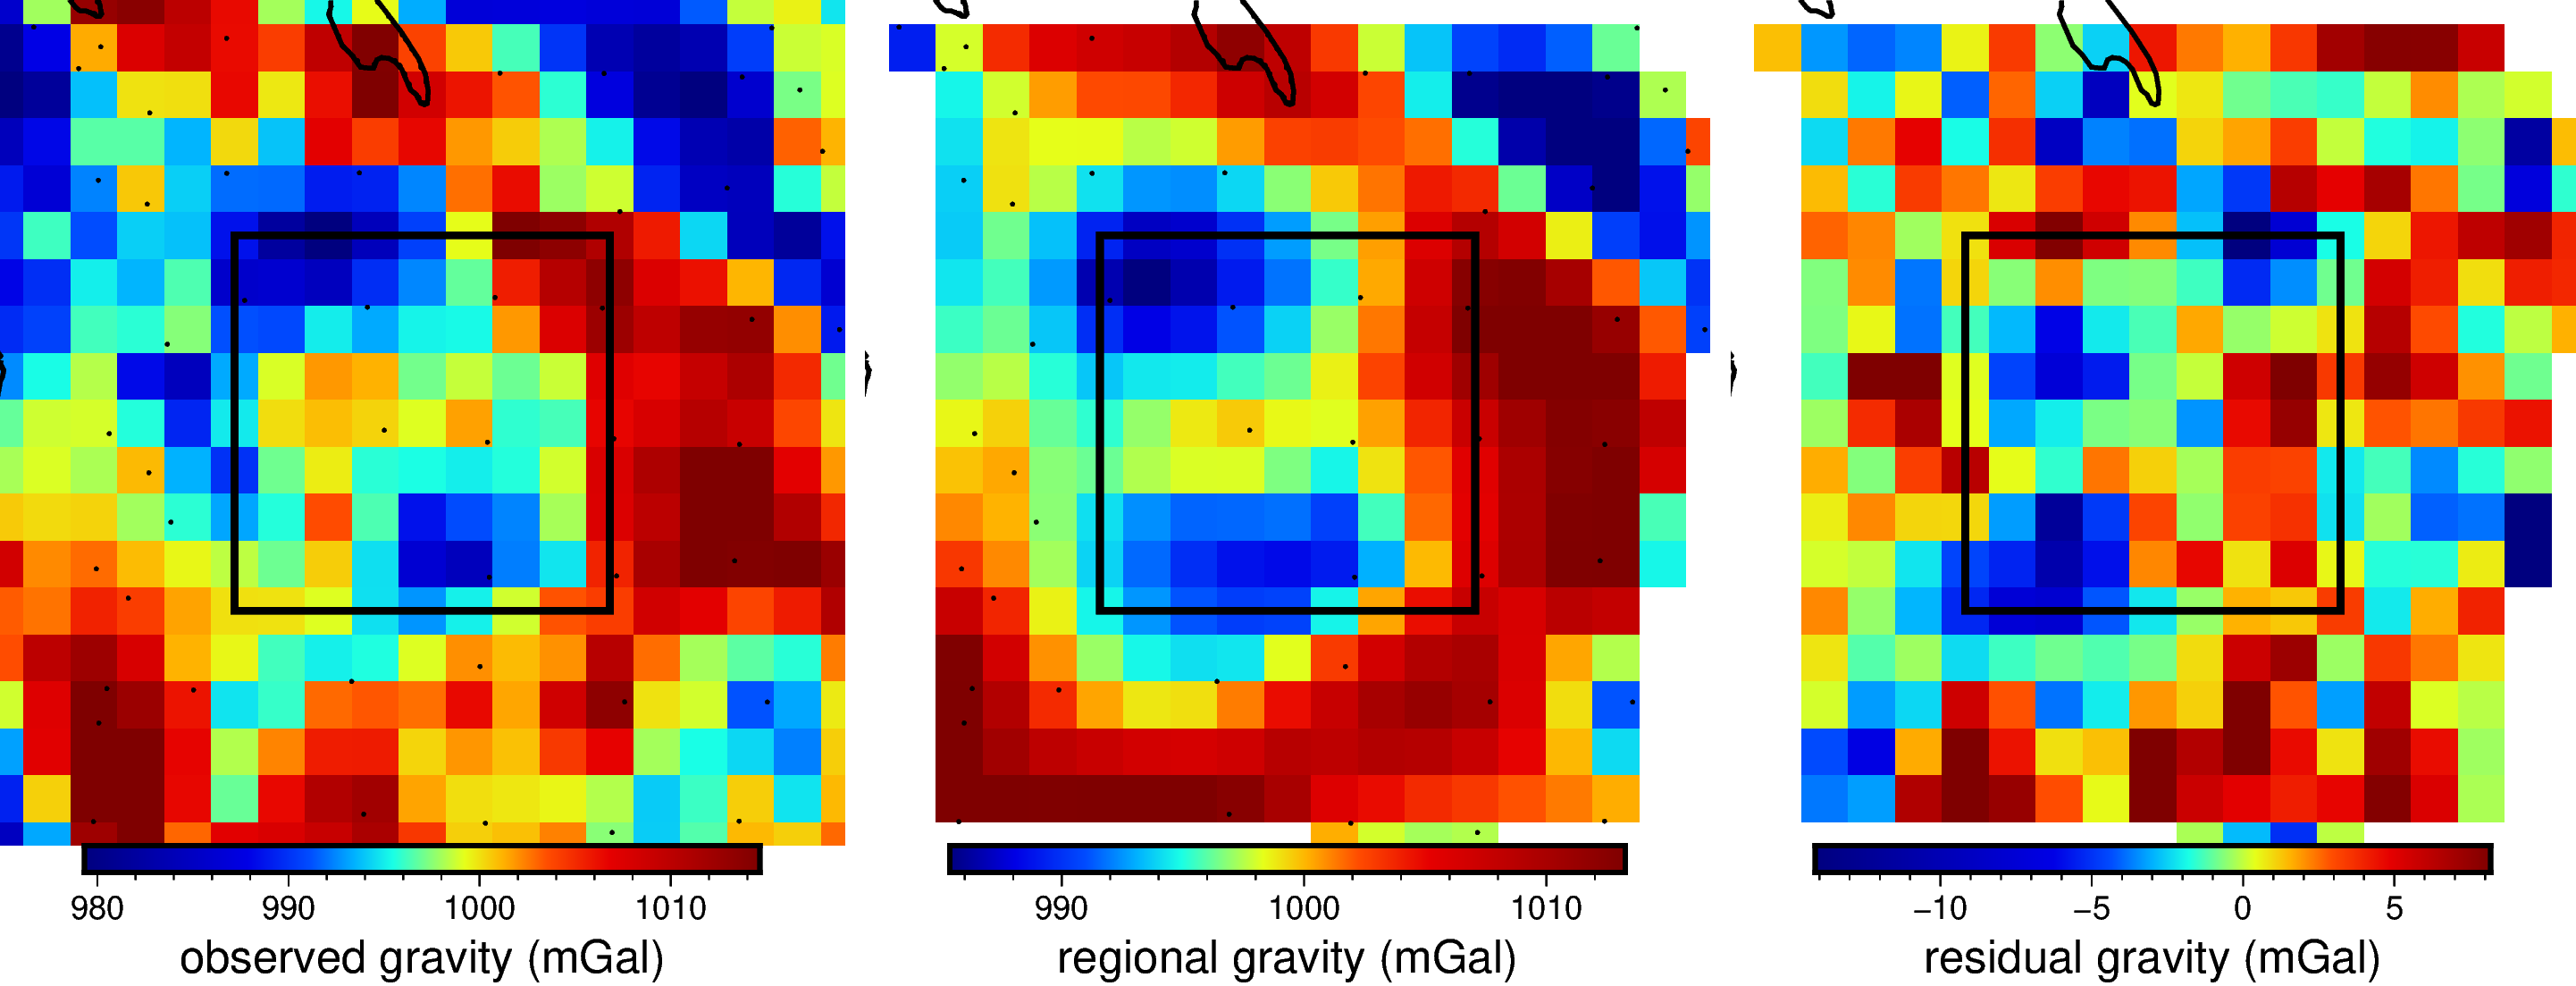

In [9]:
plot_region = inv_reg
cmap_region = fig_reg

if plot_region == inv_reg:
    projection = inv_proj
    plot_width = inv_width
elif plot_region == fig_reg:
    projection = fig_proj
    plot_width = fig_width

fig = pygmt.Figure()

# plot observed gravity
grid=observed_shift_grav_grid
pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"observed gravity (mGal)"')

plot_coast(region=plot_region, projection=projection)
plot_constraints(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)
        
fig.shift_origin(xshift=(plot_width+2)/10)

#plot regional gravity (Gobs at control points)
grid=grid_grav_constraints
pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"regional gravity (mGal)"')

plot_coast(region=plot_region, projection=projection)
plot_constraints(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

fig.shift_origin(xshift=(plot_width+2)/10)

# plot residual gravity (obs - regional)
grid=residual_grav
pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='af+l"residual gravity (mGal)"')

plot_coast(region=plot_region, projection=projection)
if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

fig.show()

# Regional prism density inversion
We want the density distribution for the basement layer to account for the regional field, so the remaining gravity anomaly, the residual, is used in the geometry-bathy inversion

To do this, will run below density inversion on the basement layer the the forward gravity total - regional gravity as the input gravity grid

In [10]:
# MATDATPAR and MAT_DENS should be matrices of len(df_grav) by len(prisms) (81x361)
    # each row is 361 long
# for 1 grav station, grav_column_der returns array of len(prism) (361)
# same for harmonica.gravity()

iteration 1
average density: 2431.020751953125
initial gravity misfit = 93
calculating Jacobian matrix to determine density correction


100%|██████████| 361/361 [00:53<00:00,  6.76it/s]


average density: 2429.630615234375
calculating updated forward gravity
100%|██████████| 361.0/361 [00:00<00:00, 25855.84it/s]
gravity misfit after iteration 1 = 85


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


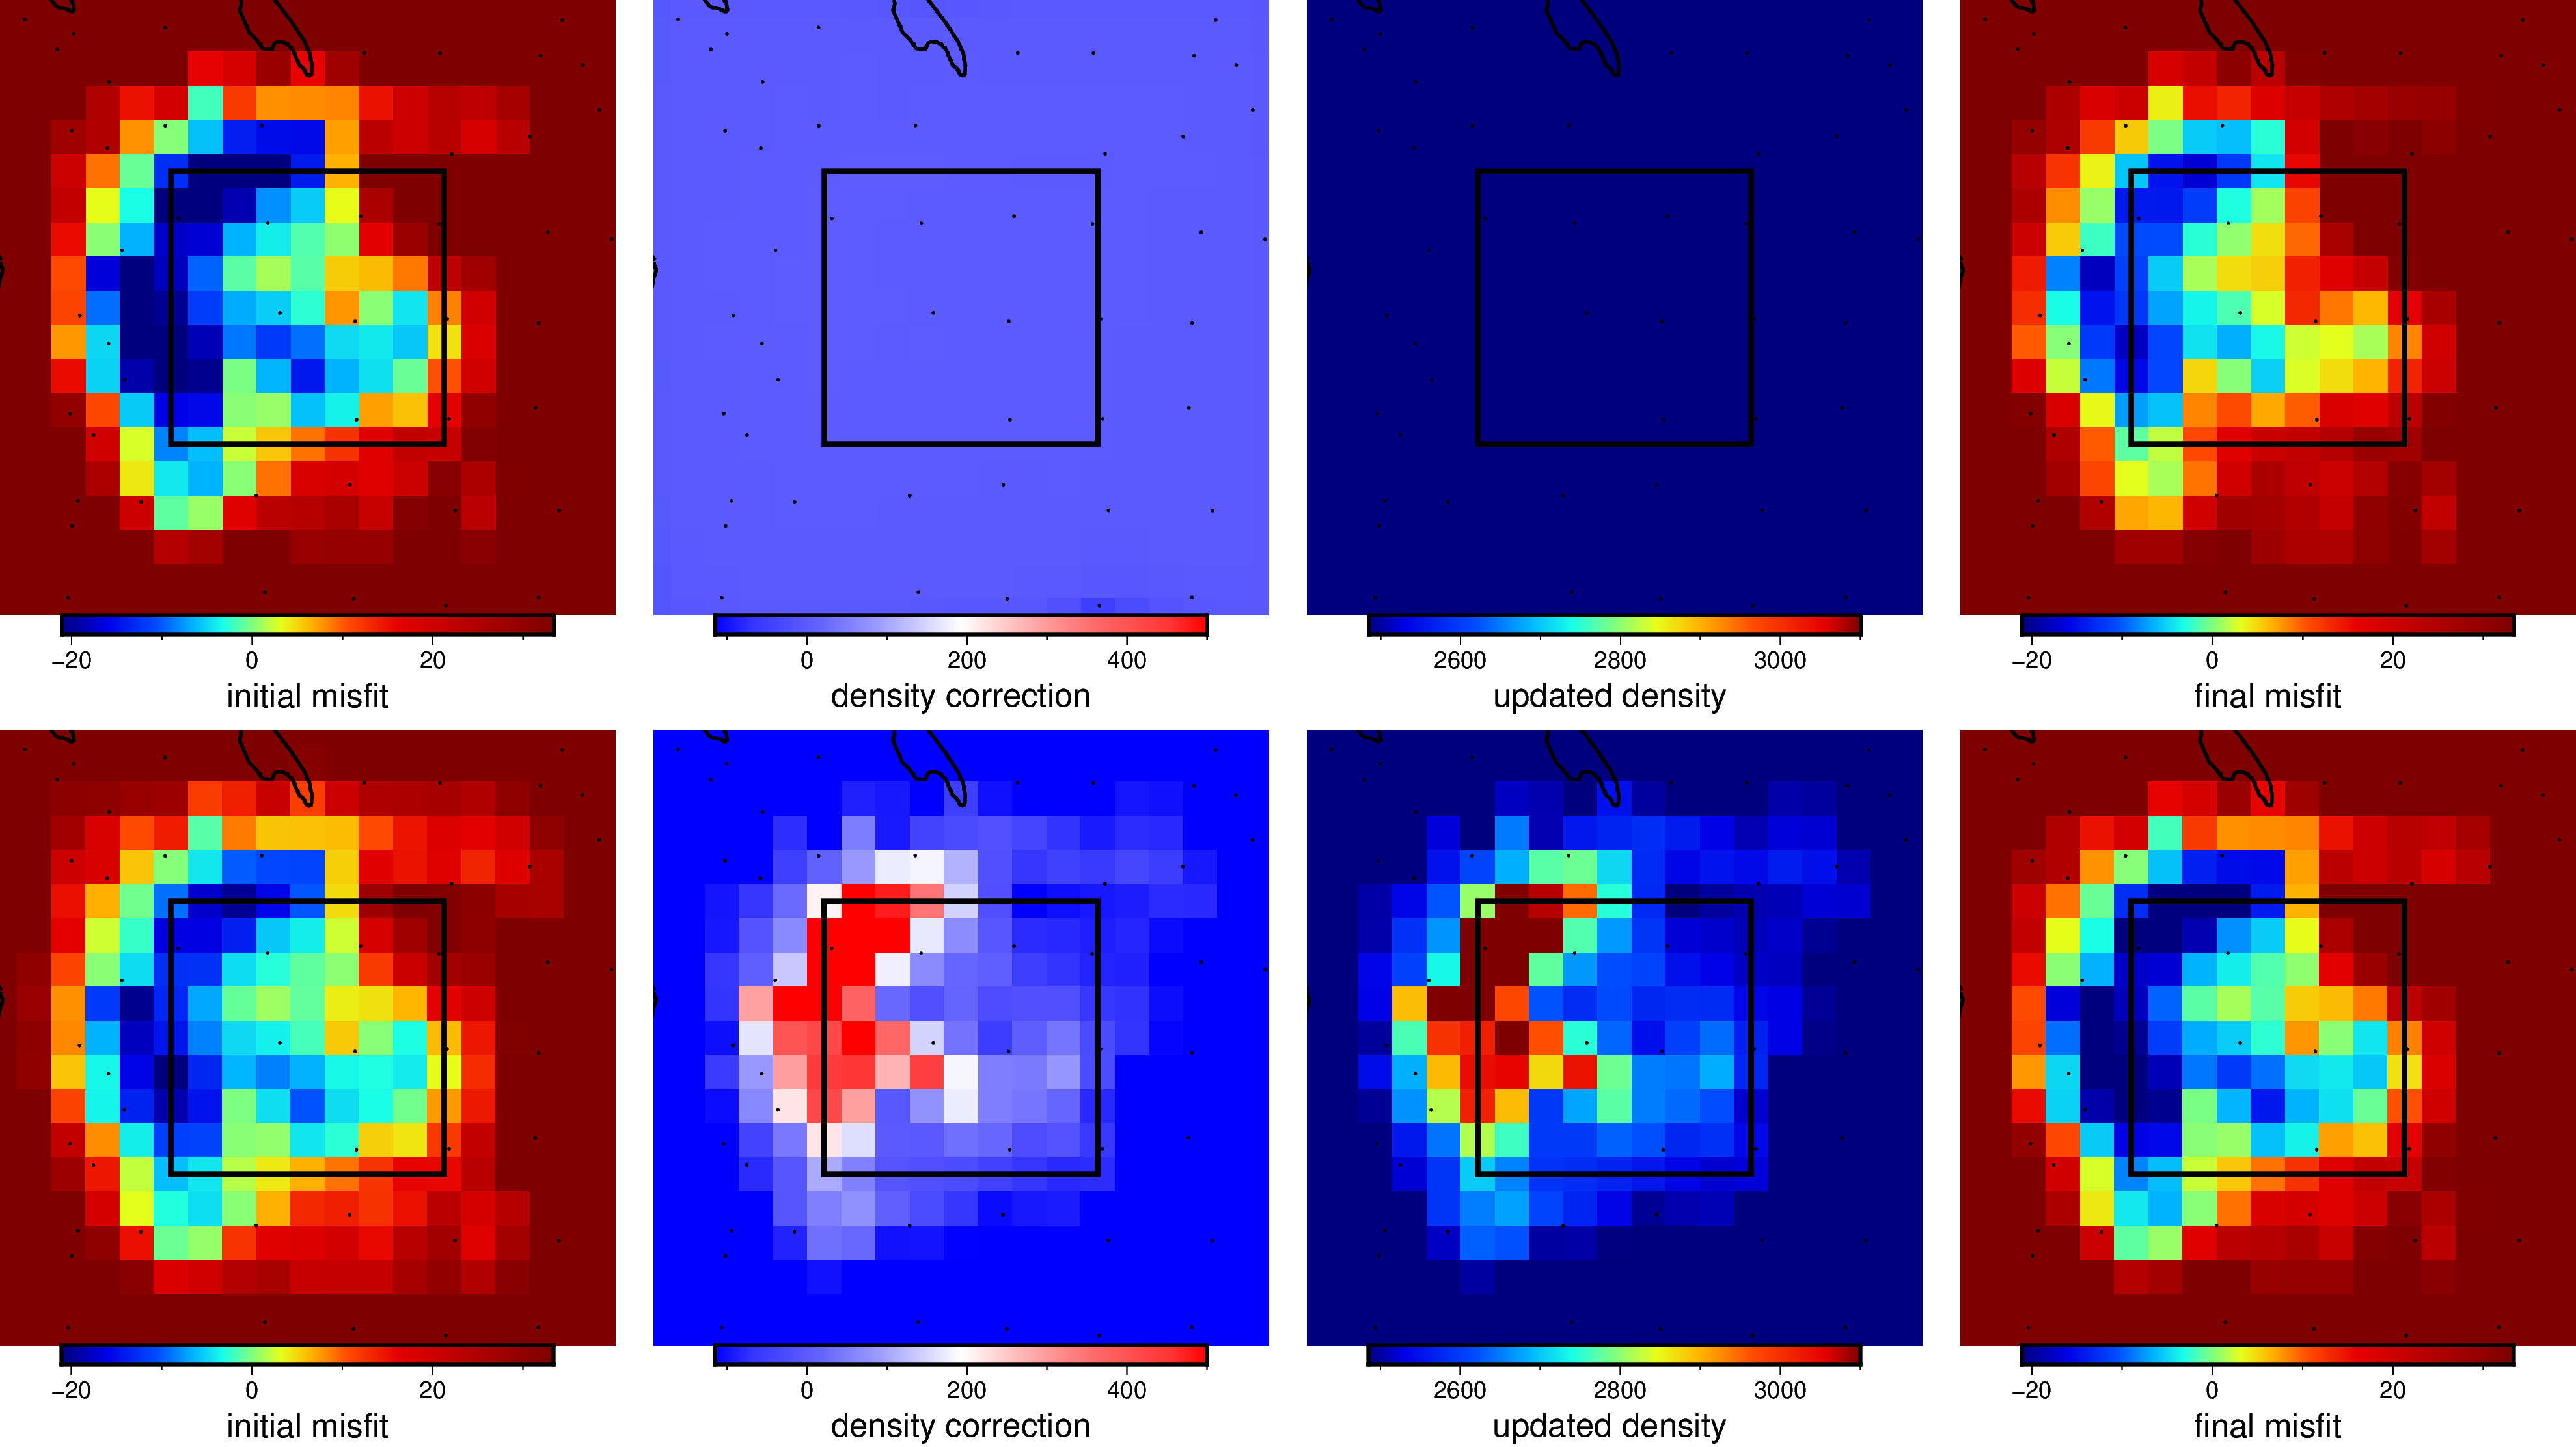

In [14]:
#########
active_layer = 'layer1'
#########

spacing = layers[active_layer]['spacing']

max_density_change=0.5
Max_Iterations=3

# df_grav = df_grav#[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()
# df_grav['inv_misfit']=df_grav.Gobs_shift-df_grav['forward_grav_total']

ITER=1
# for ITER in range(Max_Iterations):
print(f"iteration {ITER}")
prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
print(f'average density: {prisms.density.mean()}')
MAT_DENS = (np.zeros([len(df_grav),len(prisms)]))

print(f"initial gravity misfit = {int(np.sqrt((df_grav['inv_misfit'] **2).mean()))}")
print('calculating Jacobian matrix to determine density correction')
for i,j in enumerate(tqdm(df_grav.Gobs)):
    MAT_DENS[i,:] = gravbox(
                        df_grav.y.iloc[i], # coords of gravity observation points
                        df_grav.x.iloc[i],
                        df_grav.z.iloc[i],
                        prisms.northing-spacing/2, # prisms' edge coordinates
                        prisms.northing+spacing/2,
                        prisms.easting-spacing/2,
                        prisms.easting+spacing/2,
                        prisms.top,      # prisms' top
                        prisms.bottom,  # prism's bottom
                        prisms.density/1000)  # prisms' density 
# for i,j in enumerate((df_grav.Gobs)):
#     MAT_DENS[i,:] = layers[active_layer]['prisms'].prism_layer.gravity(
#         coordinates=(df_grav.x, df_grav.y, df_grav.z),
#         field = 'g_z')

# Calculate shift to prism's densities to minimize misfit
# gives the amount that each column's rho needs to change by to have the smallest misfit      
Density_correction=-lsqr(MAT_DENS,df_grav.inv_misfit,show=False)[0]

# if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Density_correction
for i in range(0,len(prisms)):
    if Density_correction[i] > max_density_change:
        Density_correction[i]=max_density_change
    elif Density_correction[i] < -max_density_change:
        Density_correction[i]=-max_density_change

# resetting the rho values with the above correction
# harmonica uses 2600, grav_box/grav_col_der uses 2.6, so density correction needs to be *1000 for harmonica
prisms['updated_density']=prisms.density+(Density_correction*1000)
dens_update = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.updated_density, 
                region=inv_reg, spacing=grav_spacing, projection=inv_proj)

# apply the rho correction to the prism layer
layers[active_layer]['prisms']['density']=dens_update
print(f"average density: {layers[active_layer]['prisms'].to_dataframe().reset_index().dropna().density.mean()}")
# recalculate forward gravity of active layer               
print('calculating updated forward gravity')
df_grav[f'forward_grav_{active_layer}_{ITER}'] = layers[active_layer]['prisms'].prism_layer.gravity(
coordinates=(df_grav.x, df_grav.y, df_grav.z),
field = 'g_z', progressbar=True)

if ITER==0:
    fig = pygmt.Figure()
else:
    pass
plot_region = inv_reg
cmap_region = fig_reg

if plot_region == inv_reg:
    projection = inv_proj
    plot_width = inv_width
    plot_height = inv_height
elif plot_region == fig_reg:
    projection = fig_proj
    plot_width = fig_width
    plot_height = fig_height

grid = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
if ITER == 0:
    pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, continuous=True, background=True, output = 'plotting/misfit.cpt')
    cmap = 'plotting/misfit.cpt'
else:
    cmap = 'plotting/misfit.cpt'
fig.grdimage( grid, cmap=cmap, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
fig.colorbar(cmap=cmap, position='jBC+jTC+h', frame='af+l"initial misfit"')
plot_coast(region=plot_region, projection=projection)
plot_constraints(region=plot_region, projection=projection)
if plot_region == inv_reg:
    plot_inv_box(projection=projection, region=plot_region)

fig.shift_origin(xshift=((plot_width+5)/10))

# Recalculation of gravity misfit, i.e., the difference between calculated and observed gravity
df_grav[f'forward_grav_total_{ITER}'] = df_grav.forward_grav_total - df_grav[f'{active_layer}_forward_grav'] + df_grav[f'forward_grav_{active_layer}_{ITER}']
df_grav['inv_misfit']=df_grav.Gobs_shift-df_grav[f'forward_grav_total_{ITER}']

print(f"gravity misfit after iteration {ITER} = {int(np.sqrt((df_grav['inv_misfit'] **2).mean()))}")

dens_correction = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=Density_correction*1000, 
                region=inv_reg, spacing=grav_spacing, projection=inv_proj)
grid = dens_correction
if ITER == 0:
    pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=cmap_region, continuous=True, background=True, output = 'plotting/dens_corr.cpt')
    cmap = 'plotting/dens_corr.cpt'
else:
    cmap = 'plotting/dens_corr.cpt'

fig.grdimage( grid, cmap=cmap, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
fig.colorbar(cmap=cmap, position='jBC+jTC+h', frame='af+l"density correction"')
plot_coast(region=plot_region, projection=projection)
plot_constraints(region=plot_region, projection=projection)
if plot_region == inv_reg:
    plot_inv_box(projection=projection, region=plot_region)

fig.shift_origin(xshift=((plot_width+5)/10))

grid = dens_update
if ITER == 0:
    pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, continuous=True, background=True, output = 'plotting/dens.cpt')
    cmap = 'plotting/dens.cpt'
else:
    cmap = 'plotting/dens.cpt'
fig.grdimage( grid, cmap=cmap, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
fig.colorbar(cmap=cmap, position='jBC+jTC+h', frame='af+l"updated density "')
plot_coast(region=plot_region, projection=projection)
plot_constraints(region=plot_region, projection=projection)
if plot_region == inv_reg:
    plot_inv_box(projection=projection, region=plot_region)

fig.shift_origin(xshift=((plot_width+5)/10))

grid = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
cmap = 'plotting/misfit.cpt'
fig.grdimage( grid, cmap=cmap, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
fig.colorbar(cmap=cmap, position='jBC+jTC+h', frame='af+l"final misfit"')
plot_coast(region=plot_region, projection=projection)
plot_constraints(region=plot_region, projection=projection)
if plot_region == inv_reg:
    plot_inv_box(projection=projection, region=plot_region)

fig.show()

fig.shift_origin(xshift=-3*((plot_width+5)/10))

fig.shift_origin(yshift=(plot_height+15)/10)


In [16]:
layers[active_layer]['prisms']
df_grav

,x,y,Gobs,z,ice_forward_grav,water_forward_grav,layer1_forward_grav,layer2_forward_grav,forward_grav_total,initial_misfit,Gobs_shift,forward_grav_misfit,regional,regional_misfit,inv_misfit,forward_grav_layer1_0,forward_grav_total_0,forward_grav_layer1_1,forward_grav_total_1
0,-260000.0,-1100000.0,-39.869999,795.313843,15.530594,7.207664,74.657504,659.587044,756.982807,-796.852806,984.785767,227.802959,NaN,NaN,232.928053,60.414638,742.739941,69.532411,751.857714
1,-260000.0,-1080000.0,-35.400002,797.866211,16.622275,7.037625,54.947762,754.188896,832.796558,-868.196559,989.255737,156.459179,NaN,NaN,160.218516,44.542699,822.391495,51.188425,829.037221
2,-260000.0,-1060000.0,-31.610001,800.015381,17.373365,7.074181,78.390126,741.484543,844.322214,-875.932215,993.045776,148.723562,NaN,NaN,154.002754,63.559097,829.491185,73.110934,839.043022
3,-260000.0,-1040000.0,-25.850000,800.439026,17.538985,8.586350,115.662096,702.654918,844.442349,-870.292349,998.805786,154.363437,NaN,NaN,162.079166,93.854005,822.634258,107.946367,836.726620
4,-260000.0,-1020000.0,-21.090000,799.789856,17.342370,8.251007,165.691908,653.289699,844.574984,-865.664984,1003.565735,158.990751,NaN,NaN,169.973548,134.681402,813.564478,154.709111,833.592187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,100000.0,-820000.0,-26.100000,790.463013,14.130211,15.585276,147.395452,662.050310,839.161249,-865.261249,998.555786,159.394537,996.973866,157.812617,169.183804,120.860921,812.626718,137.606185,829.371982
357,100000.0,-800000.0,-23.500000,791.775452,14.578145,15.433557,176.938841,626.345488,833.296032,-856.796032,1001.155762,167.859730,1002.558838,169.262806,179.585140,144.542354,800.899544,165.213432,821.570622
358,100000.0,-780000.0,-25.619999,792.327026,14.767755,15.463692,173.586206,623.466660,827.284313,-852.904312,999.035767,171.751454,NaN,NaN,183.262898,141.683784,795.381891,162.074762,815.772869
359,100000.0,-760000.0,-25.690001,794.673767,15.481858,14.432058,157.469850,626.890474,814.274240,-839.964241,998.965759,184.691519,NaN,NaN,195.167018,128.271226,785.075616,146.994352,803.798742


In [ ]:
# #########
# active_layer = 'layer1'
# #########

# grid = layers[active_layer]['grid']
# # df = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
# spacing = grav_spacing/2

# SIGMA=0
# max_density_change=.25
# Max_Iterations=2

# df_grav['grav_inversion']=df_grav.regional
# # df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()

# df_grav['inv_misfit']=df_grav.grav_inversion-df_grav['forward_grav_total']


# for ITER in range(Max_Iterations):
#     MAT_DENS = (np.zeros([grid_grav.z.values.size,grid_grav.z.values.size]))
#     print(f"iteration {ITER}")
#     print(f"initial gravity misfit = {np.sqrt((df_grav['inv_misfit'] **2).mean())}")
#     # # calculate MAT_DENS with gravbox
#     print('calculating Jacobian matrix to determine density correction')
#     for i,j in enumerate(tqdm(df_grav.Gobs)):
#         MAT_DENS[i,:] = gravbox(
#                             grid_grav.y.values[i], # coords of gravity observation points
#                             grid_grav.x.values[i],
#                             grid_grav.z.values[i],
#                             (grid_grav.y.values-spacing), # prisms' edge coordinates
#                             (grid_grav.y.values+spacing),
#                             (grid_grav.x.values-spacing),
#                             (grid_grav.x.values+spacing),
#                             -(grid.z.values),      # prisms' top
#                             0*(grid.z.values),  # prism's bottom
#                                 1)  # prisms' density 
#     misfit_grid = grid_grav_constraints.fillna(0) # fill nans in gravity grid with 0's
#     misfit_grid_FILPRE = sp.ndimage.gaussian_filter(misfit_grid, SIGMA, mode='constant')
#     AMPLITUDE = np.abs(misfit_grid).values.max()
#     AMPLITUDEPRE = np.max(np.abs(misfit_grid_FILPRE))
#     misfit_grid_FIL = AMPLITUDE*sp.ndimage.gaussian_filter(misfit_grid, SIGMA, mode='constant')/AMPLITUDEPRE

#     grav_diff_grid_filt = xr.DataArray(misfit_grid_FIL, dims=['x','y'], name='z')
#     grav_diff_grid_filt = grav_diff_grid_filt.transpose()
#     df = grav_diff_grid_filt.to_dataframe().reset_index()
#     df_grav['diffvecgrid'] = df.z
    
#     # Calculate shift to prism's densities to minimize misfit
#     # gives the amount that each column's rho needs to change by to have the smallest misfit       
#     Density_correction=-lsqr(MAT_DENS,df_grav['diffvecgrid'].values,show=False)[0]
#     # Density_correction
#     # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Density_correction
#     for i in range(0,len(df_grav)):
#         if Density_correction[i] > max_density_change:
#             Density_correction[i]=max_density_change
#         elif Density_correction[i] < -max_density_change:
#             Density_correction[i]=-max_density_change
#     df_grav['dens_correction'] = Density_correction
#     dens_correction = pygmt.xyz2grd(data = df_grav[['x','y','dens_correction']], region=inv_reg, spacing=grav_spacing, projection=inv_proj)
#     # update prism layer with new densities
#     # harmonica uses 2600, grav_box/grav_col_der uses 2.6, so density correction needs to be *1000 for harmoinca
#     layers[active_layer]['df'].rho=layers[active_layer]['df'].rho+df_grav.dens_correction*1000
#     dens_update = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.density, 
#                     region=inv_reg, spacing=grav_spacing, projection=inv_proj)
#     # apply the rho correction to the prism layer
#     layers[active_layer]['prisms']['density']=dens_update

#     #recalculate forward gravity of active layer               
#     print('calculating updated forward gravity')
#     df_grav[f'forward_grav_{active_layer}_{ITER}'] = layers[active_layer]['prisms'].prism_layer.gravity(
#     coordinates=(df_grav.x, df_grav.y, df_grav.z),
#     field = 'g_z', progressbar=True)

#     fig = pygmt.Figure()

#     plot_region = inv_reg
#     cmap_region = fig_reg

#     if plot_region == inv_reg:
#         projection = inv_proj
#         plot_width = inv_width
#     elif plot_region == fig_reg:
#         projection = fig_proj
#         plot_width = fig_width

#     grid = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
#     pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, continuous=True, background=True)
#     fig.grdimage( grid, cmap=True, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
#     fig.colorbar(cmap=True, frame='af+l"initial misfit"')
#     plot_coast(region=plot_region, projection=projection)
#     plot_constraints(region=plot_region, projection=projection)
#     if plot_region == inv_reg:
#         plot_inv_box(projection=projection, region=plot_region)

#     fig.shift_origin(xshift=(plot_width+2)/10)

#     # Calculation of gravity misfit, i.e., the difference between calculated and observed gravity
#     df_grav[f'forward_grav_total_{ITER}'] = df_grav.forward_grav_total - df_grav[f'{active_layer}_forward_grav'] + df_grav[f'forward_grav_{active_layer}_{ITER}']
#     df_grav[f'inv_misfit']=df_grav.grav_inversion-df_grav[f'forward_grav_total_{ITER}']

#     print(f"gravity misfit after iteration {ITER} = {np.sqrt((df_grav['inv_misfit'] **2).mean())}")

#     grid = dens_correction
#     try:
#         pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=cmap_region, continuous=True, background=True)
#     except:
#         print('cmap error')
#         pygmt.makecpt(cmap='polar+h0')
#     fig.grdimage( grid, cmap=True, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
#     fig.colorbar(cmap=True, frame='af+l"density correction"')
#     plot_coast(region=plot_region, projection=projection)
#     plot_constraints(region=plot_region, projection=projection)
#     if plot_region == inv_reg:
#         plot_inv_box(projection=projection, region=plot_region)

#     fig.shift_origin(xshift=(plot_width+2)/10)

#     grid = pygmt.xyz2grd(layers[active_layer]['df'][['x','y','rho']], region=inv_reg, spacing=grav_spacing)
#     try:
#         pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, continuous=True, background=True)
#     except:
#         print('cmap error')
#         pygmt.makecpt(cmap='jet')
#     fig.grdimage( grid, cmap=True, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
#     fig.colorbar(cmap=True, frame='af+l"updated density "')
#     plot_coast(region=plot_region, projection=projection)
#     plot_constraints(region=plot_region, projection=projection)
#     if plot_region == inv_reg:
#         plot_inv_box(projection=projection, region=plot_region)

#     fig.shift_origin(xshift=(plot_width+2)/10)

#     grid = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
#     pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, continuous=True, background=True)
#     fig.grdimage( grid, cmap=True, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
#     fig.colorbar(cmap=True, frame='af+l"final misfit"')
#     plot_coast(region=plot_region, projection=projection)
#     plot_constraints(region=plot_region, projection=projection)
#     if plot_region == inv_reg:
#         plot_inv_box(projection=projection, region=plot_region)

#     fig.show()

# Prism geometry inversion

In [ ]:
#########
active_layer = 'layer1'
#########

prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
# prisms_inner = prisms[(prisms.easting.between(e_fig, w_fig)) & (prisms.northing.between(n_fig, s_fig))].copy()

df_grav['grav_inversion']=df_grav.Gobs_shift
df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()

spacing = layers[active_layer]['spacing'] 
misfit_sq_tolerance=.001
delta_misfit_squared_tolerance=0.02
Max_Iterations=4
max_layer_change_per_iter=200 

MATDATPAR = (np.zeros([len(df_grav_inner),len(prisms)]))

misfit_squared_updated=np.Inf  # positive infinity
delta_misfit_squared=np.Inf  # positive infinity

df_grav_inner['inv_misfit']=df_grav_inner.grav_inversion-df_grav_inner[f'forward_grav_total']

ITER=0
 # while delta_misfit_squared (inf) is greater than 1 + least squares tolerance (0.02)
while delta_misfit_squared > 1+delta_misfit_squared_tolerance:
    ITER=ITER+1 
    print(f"iteration {ITER}")

    # get prisms' coordinates from active layer
    prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()

    # calculate MATDATPAR with grav_column_der
    print('calculating Jacobian matrix to determine surface correction')
    for i,j in enumerate(tqdm(df_grav_inner.Gobs)):
        # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
        #MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
        # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
        MATDATPAR[i,:]=grav_column_der(df_grav_inner.y.iloc[i], # coords of gravity observation points
                                               df_grav_inner.x.iloc[i],
                                               df_grav_inner.z.iloc[i],  
                                               prisms.northing, prisms.easting,     
                                               prisms.top, 
                                               prisms.bottom,
                                               spacing,     
                                               prisms.density/1000)  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath
    # Calculate shift to prism's tops to minimize misfit
    # gives the amount that each column's Z1 needs to change by to have the smallest misfit
    Surface_correction=lsqr(MATDATPAR,df_grav_inner['inv_misfit'],show=False)[0] # finds the least-squares solution to MATDATPAR and Grav_Misfit, assigns the first value to Surface_correction

    # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
    for i in range(0,len(prisms)):
        if Surface_correction[i] > max_layer_change_per_iter:
            Surface_correction[i]=max_layer_change_per_iter
        elif Surface_correction[i] < -max_layer_change_per_iter:
            Surface_correction[i]=-max_layer_change_per_iter
    
    # multiply surface correction by constraints grid, with RIGGS/onshore points =0, tapering to 1 at 5km.
    # this will change surface correction to be 0 at control points
    
    # resetting the Z values with the above corrections 
    prisms.top=prisms.top+Surface_correction

    # apply the z correction to the prism layer with Harmonica 
    layers[active_layer]['prisms'].prism_layer.update_top_bottom(pygmt.xyz2grd(prisms[['easting','northing','top']], 
                                region=inv_reg, spacing=spacing), layers[active_layer]['prisms'].bottom)
    
    # recalculate forward gravity of active layer               
    print('calculating updated forward gravity')
    df_grav_inner[f'forward_grav_{active_layer}_{ITER}'] = layers[active_layer]['prisms'].prism_layer.gravity(
    coordinates=(df_grav_inner.x, df_grav_inner.y, df_grav_inner.z),
    field = 'g_z', progressbar=True)

    # Calculation of gravity misfit, i.e., the difference between calculated and observed gravity
    # replace previous forward grav of layer with newly calculated forward grav
    df_grav_inner[f'forward_grav_total_{ITER}'] = df_grav_inner.forward_grav_total - df_grav_inner[f'{active_layer}_forward_grav'] + df_grav_inner[f'forward_grav_{active_layer}_{ITER}']
    df_grav_inner[f'inv_misfit']=df_grav_inner.grav_inversion-df_grav_inner[f'forward_grav_total_{ITER}']

    print(f"gravity misfit after iteration {ITER} = {np.sqrt((df_grav_inner['inv_misfit'] **2).mean())}")

    # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to delta_misfit_squared_tolerance (0.02)
    misfit_sq=np.mean(df_grav_inner[f'inv_misfit']**2)
    delta_misfit_squared=misfit_squared_updated/misfit_sq
    misfit_squared_updated=misfit_sq # updated 
    
    print(f"delta_misfit_squared={delta_misfit_squared}")
    print(f"Iteration {ITER} terminated with least-squares norm={int(misfit_sq)}, executing iteration {ITER+1}")
    ####
    ####
    ####
    ####
    # grid and plot the updated bathymetry, difference from starting, and gravity misfit
    plot_region = inv_reg
    cmap_region = fig_reg

    if plot_region == inv_reg:
        projection = inv_proj
        plot_width = inv_width
    elif plot_region == fig_reg:
        projection = fig_proj
        plot_width = fig_width

    fig = pygmt.Figure()

    grid=layers[active_layer]['grid'].z
    fig.grdimage(grid, cmap='globe', projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"original bathymetry (m)"')
    # plot_coast(region=plot_region, projection=projection)
    # plot_constraints(region=plot_region, projection=projection)
    if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

    fig.shift_origin(xshift=(plot_width+2)/10)
    layers[active_layer]['inv_grid']=pygmt.xyz2grd(prisms[['easting','northing','top']], region=inv_reg, spacing=spacing)
    grid=layers[active_layer]['inv_grid']
    fig.grdimage(grid, cmap='globe', projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"inverted bathymetry (m)"')
    # plot_coast(region=plot_region, projection=projection)
    # plot_constraints(region=plot_region, projection=projection)
    if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

    fig.shift_origin(xshift=(plot_width+2)/10)
    correction = pygmt.xyz2grd(x=prisms.easting,y=prisms.northing, z=Surface_correction, region=fig_reg, spacing=spacing)
    try:
        pygmt.grd2cpt(cmap="polar+h0", grid=correction, continuous=True, region=cmap_region, background=True)
    except:
        print('cmap error')
        pygmt.makecpt(cmap="polar+h0")
    fig.grdimage(correction, cmap=True, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"iteration correction (m)"')
    # plot_coast(region=plot_region, projection=projection)
    # plot_constraints(region=plot_region, projection=projection)
    if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

    fig.shift_origin(xshift=(plot_width+2)/10)
    grd_diff = layers[active_layer]['inv_grid'] - layers[active_layer]['grid'].z
    try:
        pygmt.grd2cpt(cmap="polar+h0", grid=grd_diff, continuous=True, region=cmap_region, background=True)
    except:
        print('cmap error')
        pygmt.makecpt(cmap="polar+h0")
    fig.grdimage(grd_diff, cmap=True, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"total bathymetry difference (m)"')
    # plot_coast(region=plot_region, projection=projection)
    # plot_constraints(region=plot_region, projection=projection)
    if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

    fig.shift_origin(xshift=(plot_width+2)/10)
    grid = pygmt.xyz2grd(df_grav_inner[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
    pygmt.grd2cpt(cmap="jet", grid=grid, region=cmap_region, continuous=True, background=True)
    fig.grdimage( grid, cmap=True, projection=projection, region=plot_region, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"gravity misfit (mGal)"')
    # plot_coast(region=plot_region, projection=projection)
    # plot_constraints(region=plot_region, projection=projection)
    if plot_region == inv_reg:
        plot_inv_box(projection=projection, region=plot_region)

    fig.show()

    # stop the inversion if hit the max # iterations or it's below the Least Squares norm 
    if ITER==Max_Iterations:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because maximum number of iterations ({Max_Iterations}) reached")
        break
    if misfit_sq < misfit_sq_tolerance:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because least-squares norm < {misfit_sq_tolerance}")
        break

# end of inversion iteration WHILE loop
if delta_misfit_squared < 1+delta_misfit_squared_tolerance:
    print("terminated - no significant variation in least-squares norm ")

In [ ]:
# Fabio's test grids
# inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_gravity_10000m_lr.nc -Ginversion_layers/gravity_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_ice_10000m_lr.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_water_10000m_lr.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_layer1_10000m_lr.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -I20e3  inversion_layers/base_RIS_layer2_20000m_lr.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 

# surface = xr.load_dataarray("../inversion_layers/BedMachine_surface_5k_filled.nc")
# icebase = xr.load_dataarray("../inversion_layers/BedMachine_icebase_5k_filled.nc")
# bed = xr.load_dataarray("../inversion_layers/BedMachine_bed_5k.nc")
# basement = xr.load_dataarray("../inversion_layers/ROSETTA_basement_BedMachine_bed.nc", drop_variables='polar_stereographic')
# grav = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/gravity_inv.nc')

# surface = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_inv.nc')
# icebase = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_inv.nc')
# bed = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_inv.nc')
# basement = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc')

# df_grav=grav.to_dataframe().reset_index()
# df_grav.rename(columns={'z':'Gobs'}, inplace=True)
# # df_grav['z']=750
# df_grav['z']=surface.to_dataframe().reset_index().z+750
# df_grav

In [ ]:
# TREND_TYPE = 'Constant value'
# # TREND_TYPE = 'Linear'
# # TREND_TYPE = 'Full regional correction'

# # set type of regional correction
# if TREND_TYPE == "Constant value":
#     df_grav['regional_grav'] = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean()
#     # df_grav['regional_grav'] = df_grav.forward_grav_misfit.mean()
#     print(df_grav['regional_grav'].mean())

# elif TREND_TYPE == 'Linear':
#     # ATEMP=np.column_stack((np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])), 
#     #                         df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]))
#     #                         df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))], 
#     # C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])
#     # df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])) + C[1]*df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))] + C[2]*df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]
#     ATEMP=np.column_stack((np.ones(len(df_grav.Gobs)), 
#                             df_grav.x, 
#                             df_grav.y))
#     C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit)
#     df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs)) + C[1]*df_grav.y + C[2]*df_grav.x
#     # print(C[0])
    
# elif TREND_TYPE == 'Full regional correction':
#      df_grav['regional_grav'] = df_grav.forward_grav_misfit

# # calculate residual gravity to be inverted
# df_grav['residual_grav'] = df_grav.Gobs - df_grav.regional_grav 

# residual_grav_grid=pygmt.surface(data = df_grav[['x','y','residual_grav']],
#                                  region=inv_reg, 
#                                  spacing=grav_spacing, 
#                                  M='1c', 
#                                  registration='g')

# regional_grav_grid=pygmt.surface(data = df_grav[['x','y','regional_grav']],
#                                  region=inv_reg, 
#                                  spacing=grav_spacing, 
#                                  M='1c', 
#                                  registration='g')

# # plot the grids
# fig = pygmt.Figure()

# # plot observed gravity
# data=grid_grav.z
# pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# fig.grdimage(
#         data,
#         cmap=True,
#         projection=fig_proj, 
#         region=fig_reg,
#         nan_transparent=True,
#         frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"observed gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# # plot regional gravity
# fig.shift_origin(xshift=(fig_width)/10)
# data=regional_grav_grid
# try:
#     pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
#     # pygmt.makecpt(cmap="jet", series=[data.min().item(), data.max().item()], background=True)
# except:
#     pass
# fig.grdimage(
#     data,
#     cmap=True,
#     projection=fig_proj, 
#     region=fig_reg,
#     nan_transparent=True,
#     frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"regional gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# # plot residual gravity
# fig.shift_origin(xshift=(fig_width+1)/10)
# data=residual_grav_grid
# pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# fig.grdimage(
#     data,
#     cmap=True,
#     projection=fig_proj, 
#     region=fig_reg,
#     nan_transparent=True,
#     frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"residual gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# fig.show()
# df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].describe()

In [ ]:
# #########
# active_layer = 'layer1'
# #########

# df_grav['grav_inversion']=df_grav.Gobs_shift

# df = layers[active_layer]['prisms'].to_dataframe().reset_index()

# MATDATPAR = (np.zeros([len(df_grav),len(df)])) # array with NG number of rows and NBath+NBase+NM number of columns


# spacing = layers[active_layer]['spacing'] 

# for i,j in enumerate(tqdm(df_grav.Gobs)):
#     # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
#     #MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
#     # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
#     MATDATPAR[i,0:len(df)]=grav_column_der(df_grav.y.iloc[i], # coords of gravity observation points
#                                             df_grav.x.iloc[i],
#                                             df_grav.z.iloc[i],  
#                                             df.northing, df.easting,     
#                                             df.top, 
#                                             df.bottom,
#                                             spacing,     
#                                             df.density/1000)  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath
# MATDATPAR

In [ ]:
# same as above but with matplotlib
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(ncols=1+len(layers), figsize=(5*(1+len(layers)),4))

# # GRAVITY PLOT
# grid_grav.z.plot(ax=axes[0], cmap='coolwarm', robust=True)
# axes[0].set_title('Observed gravity')

# # LAYERS PLOTS
# for i, (k, v) in enumerate(layers.items()):
#     layers[k]['grid'].z.plot(ax=axes[i+1], cmap='terrain', vmin=-10000, vmax=10000, center=0, robust=True)
#     axes[i+1].set_title(f'{k} elevation')

# # ALL PLOTS
# for i in axes:
#     i.set_aspect('equal')
#     i.add_patch(mpl.patches.Rectangle(
#     (e_fig, n_fig), w_fig-e_fig, s_fig-n_fig, lw=2, fill=False) ) 

# plt.tight_layout()


In [ ]:
# from pygmt import session_management
# session_management.end()
# session_management.begin()
